## Comparisons Between all the Algorithms


In [184]:
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [185]:
RADIX = "Radix"
BITONIC = "Bitonic"
QUICK = "Quicksort"
MERGE = "Merge"

MPI = "MPI"
CUDA = "CUDA"

RANDOM = "random"
SORTED = "sorted"
REVERSE = "reverse"
PERTURBED = "perturbed"

ALGORITHMS = [RADIX, MERGE, QUICK]
ALGORITHMS = []
ALGORITHMS_CUDA = [RADIX, MERGE]

PROGRAMMING_MODEL = [MPI, CUDA]
INPUT_TYPES = [RANDOM, SORTED, REVERSE, PERTURBED]

INPUT_TYPE = RANDOM
TIME_TYPE = "Avg time/rank"


INPUT_SIZES = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]


In [186]:
def getFilePath(algorithm, programmingModel, inputType):
  return f"dataFiles/{programmingModel}/{algorithm}/{inputType}/*.cali"

In [187]:
# MPI
filesList = []
tks = []

for algorithm in ALGORITHMS:
  filePath = getFilePath(algorithm=algorithm, programmingModel=MPI, inputType=INPUT_TYPE)
  filesList.append(glob(filePath))


for files in filesList:
  tk = th.Thicket.from_caliperreader(files)
  tks.append(tk)

# CUDA
filesListCuda = []
tksCuda = []

for algorithm in ALGORITHMS_CUDA:
  filePath = getFilePath(algorithm=algorithm, programmingModel=CUDA, inputType=INPUT_TYPE)
  filesListCuda.append(glob(filePath))

for files in filesListCuda:
  tk = th.Thicket.from_caliperreader(files)
  tksCuda.append(tk)

In [188]:
gbs = []
for tk in tks:
  gbs.append(tk.groupby("InputSize"))

gbsCuda = []
for tk in tksCuda:
  gbsCuda.append(tk.groupby("InputSize"))

7  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000017400780D10>, 262144: <thicket.thicket.Thicket object at 0x0000017400E33950>, 1048576: <thicket.thicket.Thicket object at 0x0000017403F60890>, 4194304: <thicket.thicket.Thicket object at 0x00000174041CE9D0>, 16777216: <thicket.thicket.Thicket object at 0x000001740342BD90>, 67108864: <thicket.thicket.Thicket object at 0x0000017403EDE2D0>, 268435456: <thicket.thicket.Thicket object at 0x0000017403957650>}
7  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000017403FE5890>, 262144: <thicket.thicket.Thicket object at 0x00000174037FEED0>, 1048576: <thicket.thicket.Thicket object at 0x00000174075DA1D0>, 4194304: <thicket.thicket.Thicket object at 0x00000174039520D0>, 16777216: <thicket.thicket.Thicket object at 0x00000174063DDDD0>, 67108864: <thicket.thicket.Thicket object at 0x0000017403E9DAD0>, 268435456: <thicket.thicket.Thicket object at 0x0000017406365B10>}


In [189]:

# MPI
ctks = []

for gb in gbs:
  ctk = th.Thicket.concat_thickets(
    thickets=list(gb.values()),
    headers=list(gb.keys()),
    axis="columns",
    metadata_key="num_procs"
  )
  ctks.append(ctk)

# CUDA
ctksCuda = []

for gb in gbsCuda:
  ctk = th.Thicket.concat_thickets(
    thickets=list(gb.values()),
    headers=list(gb.keys()),
    axis="columns",
    metadata_key="num_procs"
  )
  ctksCuda.append(ctk)

In [190]:
# Clean up Data
remove_list = [("node", "")]

for inputSize in INPUT_SIZES:
  remove_list.append((inputSize, "nid"))
  remove_list.append((inputSize, "spot.channel"))
  remove_list.append((inputSize, "Total time"))

print(remove_list)
for i, ctk in enumerate(ctks):
  ctk.dataframe = ctk.dataframe.reset_index().drop(remove_list, axis=1)

for i, ctk in enumerate(ctksCuda):
  ctk.dataframe = ctk.dataframe.reset_index().drop(remove_list, axis=1)


[('node', ''), (65536, 'nid'), (65536, 'spot.channel'), (65536, 'Total time'), (262144, 'nid'), (262144, 'spot.channel'), (262144, 'Total time'), (1048576, 'nid'), (1048576, 'spot.channel'), (1048576, 'Total time'), (4194304, 'nid'), (4194304, 'spot.channel'), (4194304, 'Total time'), (16777216, 'nid'), (16777216, 'spot.channel'), (16777216, 'Total time'), (67108864, 'nid'), (67108864, 'spot.channel'), (67108864, 'Total time'), (268435456, 'nid'), (268435456, 'spot.channel'), (268435456, 'Total time')]


In [191]:

'''
{dataName: str}: 'main', 'comm', 'comp', etc...
returns: dictionary of collected graph of each algorithm in ALGORITHMS
'''
def collectRegion(dataName):
  res = {}

  for i, ctk in enumerate(ctks):
    algoName = ALGORITHMS[i]
    val = ctk.dataframe.loc[ctk.dataframe['name'] == dataName]
    res[f"{algoName}MPI"] = val


  for i, ctk in enumerate(ctksCuda):
    algoName = ALGORITHMS_CUDA[i]
    val = ctk.dataframe.loc[ctk.dataframe['name'] == dataName]
    res[f"{algoName}CUDA"] = val

  return res


  
res = collectRegion("main")


In [192]:

def strong_scaling_plot(inputSize, region):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.set_title(f"Strong Scaling {region} at {inputSize} Values on {INPUT_TYPE} Data")
  ax.set_xlabel("num procs")
  ax.set_ylabel("Time (s)")

  mainRegions = collectRegion(region)

  for k in mainRegions.keys():
    dframe =  mainRegions[k]
    xvals = list(dframe['num_procs'])
    yvals = list(dframe[inputSize][TIME_TYPE])
    ax.plot(xvals, yvals, label=k)

  ax.legend()
  plt.xscale("log", base=2)
  plt.show()

  


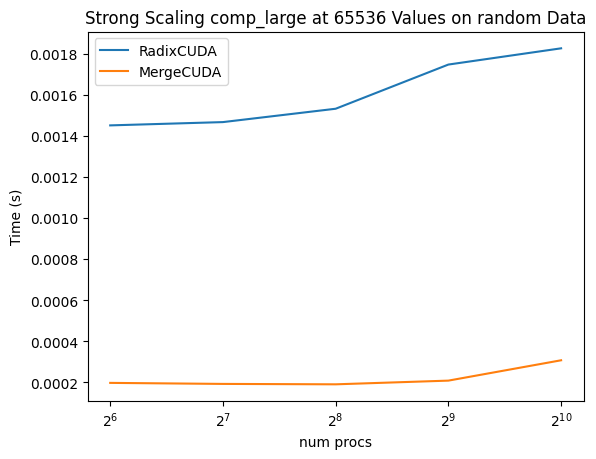

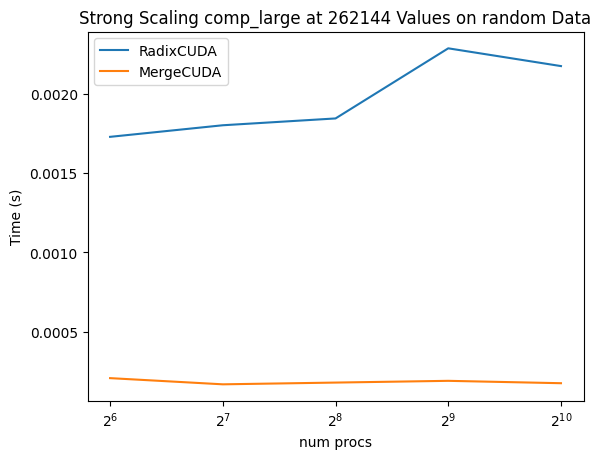

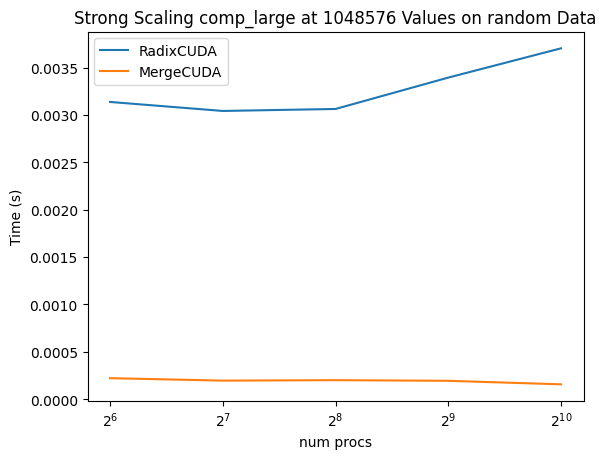

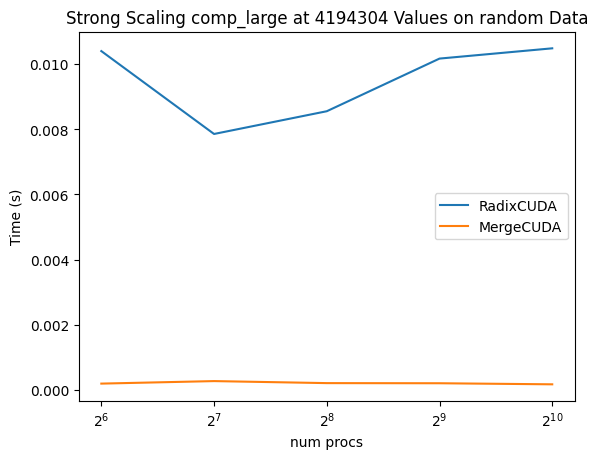

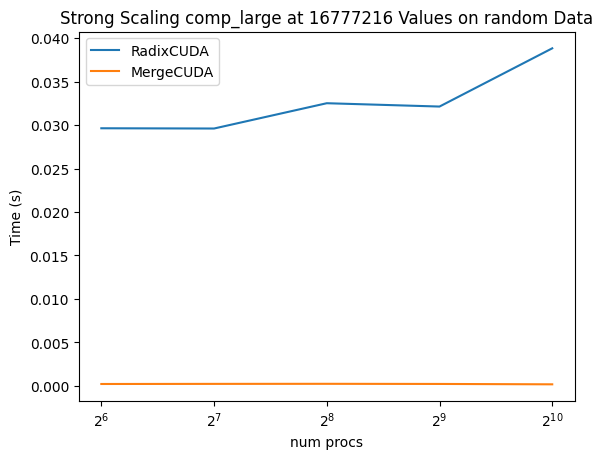

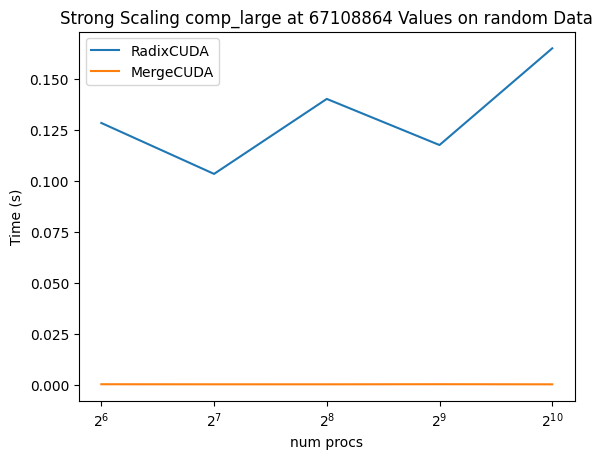

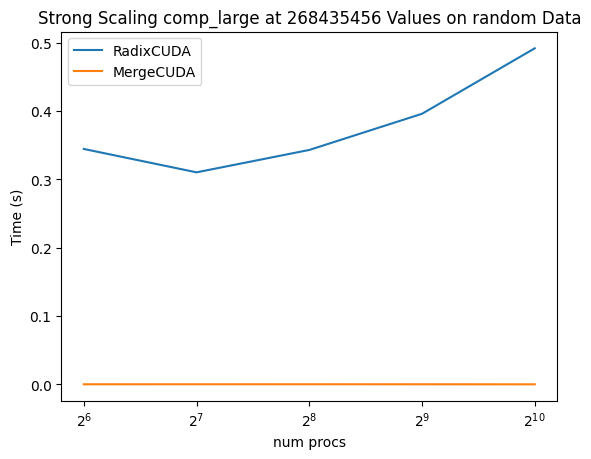

In [193]:
inputSize = INPUT_SIZES[-2]
region = 'comp_large'

for inputSize in INPUT_SIZES:
  strong_scaling_plot(inputSize, "comp_large")